In [1]:
!apt-get -y install openjdk-8-jdk-headless
!wget http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install findspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u191-b12-2ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
--2019-03-06 02:22:28--  http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 64.50.236.52, 140.211.166.134, 64.50.233.100, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|64.50.236.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227893062 (217M) [application/x-gzip]
Saving to: ‘spark-2.4.0-bin-hadoop2.7.tgz’

spark-2.4.0-bin-had 100%[===================>] 217.33M  54.4MB/s    in 15s     

2019-03-06 02:22:43 (14.6 MB/s) - ‘spark-2.4.0-bin-hadoop2.7.tgz’ saved [227893062/227893062]



In [0]:
import os

# setup environment variables
os.environ["JAVA_HOME"] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ["SPARK_HOME"] = '/content/spark-2.4.0-bin-hadoop2.7'
os.environ['KAGGLE_USERNAME'] = 'ronaldsumbayak'
os.environ['KAGGLE_KEY'] = '771009dffffa0cd0883d5fb98594d756'

In [3]:
# download dataset
!kaggle datasets download -d kmader/aminer-academic-citation-dataset
!unzip aminer-academic-citation-dataset.zip -d data

100% 2.26G/2.27G [00:40<00:00, 33.6MB/s]
100% 2.27G/2.27G [00:40<00:00, 60.2MB/s]
Archive:  aminer-academic-citation-dataset.zip
  inflating: data/dblp-ref-1.json    
  inflating: data/citation-network2.txt  
  inflating: data/AMiner-Author.txt  
  inflating: data/dblp-ref-2.json    
  inflating: data/AMiner-Coauthor.txt  
  inflating: data/dblp-ref-0.json    
  inflating: data/dblp-ref-3.json    


In [0]:
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession, functions as F

In [0]:
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [0]:
from functools import reduce

dblp_refs = [spark.read.json('data/dblp-ref-0.json'),
             spark.read.json('data/dblp-ref-1.json'),
             spark.read.json('data/dblp-ref-2.json'),
             spark.read.json('data/dblp-ref-3.json')]
df = reduce(lambda x, f: f.union(x), dblp_refs)

In [8]:
df.count()

3079007

In [9]:
df.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|AdaBoost algorith...|[Zheng Xu, Runbin...|001eef4f-1d00-4ae...|         0|[0a11984c-ab6e-4b...|A Heterogeneous S...|high performance ...|2016|
|In this paper, a ...|[Yufei Liang, Yan...|002e0b7e-d62f-414...|         0|                  []|A novel conformal...|international con...|2016|
|This paper studie...|[Xiaodong Ai, Key...|00352759-f0a7-467...|         0|[1862a08a-08c6-4a...|A source-seeking ...|international con...|2016|
|                null|[Francine Berman,...|00f77fa9-ae49-493...|         0|                  []|Social and ethica...|Communications of..

In [0]:
annual_paper_count = df.groupBy('year').count().orderBy('year', ascending=False)

In [11]:
annual_paper_count.show()

+----+------+
|year| count|
+----+------+
|2018|    38|
|2017| 81735|
|2016|232456|
|2015|227225|
|2014|223664|
|2013|214892|
|2012|207237|
|2011|196227|
|2010|182181|
|2009|175808|
|2008|159074|
|2007|148432|
|2006|135939|
|2005|120765|
|2004|101895|
|2003| 83106|
|2002| 69305|
|2001| 60743|
|2000| 55743|
|1999| 47934|
+----+------+
only showing top 20 rows



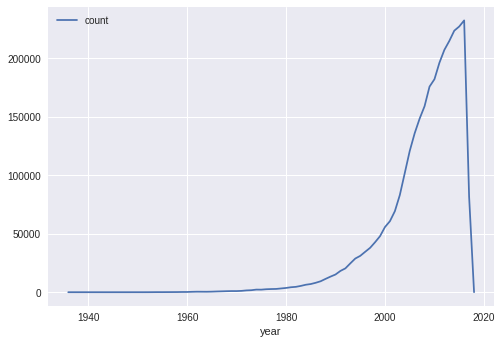

In [12]:
annual_paper_count.toPandas().plot(x='year', y='count')

In [13]:
n_citation_avg = df.agg(F.avg('n_citation')).collect()[0][0]
print('Average number of citation per paper:', int(n_citation_avg))

Average number of citation per paper: 35


In [14]:
yv = df.groupBy('year', 'venue') \
       .count() \
       .where('venue != ""')
ym = df.groupBy('year', 'venue') \
       .count() \
       .where('venue != ""') \
       .groupBy('year') \
       .agg(F.max('count').alias('count'))

vy = ym.join(yv, ['year', 'count'], 'left') \
       .orderBy('year', ascending=False)
vy.show()

+----+-----+--------------------+
|year|count|               venue|
+----+-----+--------------------+
|2018|   13|  Information Fusion|
|2017|  946|             Sensors|
|2016| 1835|             Sensors|
|2015| 2056|international con...|
|2014| 2001|global communicat...|
|2013| 1762|international con...|
|2012| 1793|international geo...|
|2011| 1595|Expert Systems Wi...|
|2010| 1364|international con...|
|2009| 1326|conference on dec...|
|2008| 1305|international con...|
|2007| 1307|international con...|
|2006| 7143|Lecture Notes in ...|
|2005| 4579|Lecture Notes in ...|
|2004| 4677|Lecture Notes in ...|
|2003| 3199|Lecture Notes in ...|
|2002| 3285|Lecture Notes in ...|
|2001| 2374|Lecture Notes in ...|
|2000| 1655|Lecture Notes in ...|
|1999| 1178|Lecture Notes in ...|
+----+-----+--------------------+
only showing top 20 rows

